In [12]:
# Imports

import math
import numpy as np
import pandas as pd
import random

from matplotlib import pyplot as plt

import plotly.express as px
from sklearn.decomposition import PCA

path = ""

In [13]:
# load datasets from drive

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks/" 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# distance method

def distance(instance, centroid, mode:str = 'euc') -> float:
  """
    Parameters
    ----------
      instance
      centroid

      mode = {
        'ave': Average,
        'euc': Euclidean,
        'man': Manhattan
      }
    
    Return
    ----------
    float
      value of distance between p and q
  """
  # init variables
  soma = 0
  n = 1
  diff = 0
  ret = 0

  # """
  # forech 
  for index in range(len(instance)):
    for col in instance:
      # print("{} \t\t\t {} ".format(index, col))
      instance_val = instance.iloc[index][col]
      centroid_val = centroid.get(col, None)
      # print("{} \t\t\t {} \t\t\t {} \t\t\t {} \t\t\t {}".format(index, col, instance_val, centroid_val, type(instance_val)))

      if col != 'name' and (type(instance_val) != str): 
        
        diff = float(instance_val) - float(centroid_val)
        if mode == 'man':
          soma += abs(diff)
        else:
          soma += pow(diff, 2)
    
  if mode == 'man':
    ret = soma
  else:
    if mode == 'ave':
      n = 1 / len(instance)
    ret = math.sqrt(n * soma)
  # """ 
  return ret


In [3]:
# init random centroids method

def init_centroids(instances, k_param:int) -> list:
  """
    Parameters
    ----------
      instances = list of instances
      k_param = number of centroids
    
    Return
    ----------
    list
      k centroids
  """ 

  centroids = []

  # each K
  for i in range(k_param):
    center = {}
    center['centroid'] =str(i)

    # foreach column in instances
    for col in instances:
      min = instances[col].min()
      max = instances[col].max()
      
      # if column is numeric
      if type(min) != str:
        # create ramdom column value
        center[col] = random.uniform(min, max)
    
    # append i centrid in list
    centroids.append(center)
  
  return centroids


In [4]:
# argmin distance centroid method

def min_centroid(instance, centroids:list, dist_mode:str) -> int:
  dist = []

  for center in centroids:
    val = distance(instance, center, dist_mode)
    dist.append(val)
    # print(val)

  return np.argmin(dist)


In [5]:
# check diff between two list of dicts

def is_updated(old_list, new_list):
  # foreach dict in old_list
  for d in old_list:
    # if dict not in new_list
    if d not in new_list:
      # return positive and new_list
      return True, new_list

  # return negative and old_list
  return False, old_list
  

In [6]:
# update centroid values method

def update_centroid(centroid, instances):
  centroid_instances = instances.loc[instances['centroid'] == centroid['centroid']]

  # print(centroid_instances.describe())
  # print_line()

  for col in centroid_instances:
    if col not in ['centroid']:
      mean = centroid_instances[col].mean()
      if type(mean) != str:
        centroid[col] = mean

  return centroid


In [7]:
# k means method

def k_means(instances, k_param:int, dist_mode:str, loop_limit=1000, centroids=False) -> list:
  """
    Parameters
    ----------
      instances = list of instances
      k_param = number of partitions
      dist_mode = distance measure
    
    Return
    ----------
    list
      k centroids results
  """

  had_update = True
  count = 0
  
  if centroids == False:
    centroids = init_centroids(instances, k_param)

  # print(instances)
  # print_line()
  # print(centroids)
  # print_line()

  # plot_dataset(pd.DataFrame(centroids), x='Murder', y='Assault', title='initial centroids')

  while had_update and count < loop_limit:
    for i in range(len(instances)):
      center_index = min_centroid(instances.iloc[[i]], centroids, dist_mode)
      # instances.iloc[i]['centroid'] = str(center_index)
      instances.at[i, 'centroid'] = str(center_index)

    # updated_centroids = centroids
    updated_centroids = []
    for center in centroids:
      new_center = update_centroid(center, instances)
      updated_centroids.append(new_center)
    
    had_update, centroids = is_updated(centroids, updated_centroids)
    count += 1

  # print_line()
  # print(instances)
  # print_line()
  # print(centroids)
  # print_line()

  print(count)
  print_line()

  return centroids


In [27]:
def dissimilarity(instances, k_param:int, dist_mode:str, loop_limit=1000):
    executions = []
    for i in range(10):
        execution_centroids = k_means(instances, k_param, dist_mode, loop_limit)
        dissimilaridade = 0 
        for k in range(k_param):
            dis = distance(instances.loc[instances['centroid']==str(k)], execution_centroids[k], dist_mode)
            dis = pow(dis, 2)
            dissimilaridade = dissimilaridade + dis
        
        executions.append({"centroids":execution_centroids, "dissimilarity":dissimilaridade})
    
    # print(executions)
    #select min dissimilarity
    optimal = min(executions, key=lambda x:x['dissimilarity']) #compares second element of each tuple
    return optimal
    
        

In [28]:
def elbow_method(instances, dist_mode:str, loop_limit=1000):
    k_execution = []
    for k in range(1, 11):
        optimal = dissimilarity(instances, k, dist_mode, loop_limit)
        k_execution.append({"k":k, "dissimilarity":optimal["dissimilarity"], "centroids":optimal["centroids"]})

    df = pd.DataFrame(k_execution)
    plot_dataset(df,x='k',y='dissimilarity')
    return k_execution

In [10]:
# plot dataframe 2D

def plot_dataset(df, x, y, color='black', title=''):
  df.plot(kind='scatter',x=x,y=y,color=color, grid=True, title=title)
  plt.show()


def print_line():
  print('\n' + '-'*30 + '\n')  

In [14]:
# read dataset

dataset = pd.read_csv(path+"dataset/MusicAndMovies_Vars.txt", sep="\t", header=0)
dataset.insert(0,'centroid', 'empty')
sample = dataset[['centroid', 'Punk', 'Fantasy.Fairy.tales']]
sample = sample.sample(n=len(sample))
sample = sample.reset_index(drop=True)


In [ ]:
#dissimilaridade

execution_centroids = elbow_method(sample,'euc', 1000)


In [ ]:
#main

#read dataset
#pandas can read from txt files. As our files are typed with tabs '\t', we can use that as separators

# dataset = pd.read_csv("dataset/MusicAndMovies_Vars.txt", sep="\t", header=0)
# dataset.insert(0,'centroid', 'empty')
# sample = dataset.sample(n=len(dataset))
# sample = sample.reset_index(drop=True)

k_param = 4
centroids = k_means(sample, k_param, "euc", 1000)

# plot k-means
dfn = pd.DataFrame(centroids)
dfn = dfn.append(sample, ignore_index=True)

colors = ['black'] * k_param

for i in range(len(sample)):
  c = sample.iloc[i]['centroid']
  colors.append('C'+c)


plot_dataset(dfn, x='Punk', y='Fantasy.Fairy.tales', color=colors, title='Results K-means')


In [38]:
# Test PCA

df = pd.read_csv(path+"dataset/MusicAndMovies_Vars.txt", sep="\t", header=0)
df.insert(0,'centroid', 'empty')

sample = df[['centroid', "Dance",	"Folk",	"Country",	"Pop",	"Rock", "Horror",	"Thriller",	"Comedy",	"Romantic",	"Sci.fi"]]
sample = sample.sample(n=len(sample))
sample = sample.reset_index(drop=True)

# elbow_method(sample,'euc', 1000)

k_param = 3
centroids = k_means(sample, k_param, "euc", 1000)

X = sample[["Dance",	"Folk",	"Country",	"Pop",	"Rock", "Horror",	"Thriller",	"Comedy",	"Romantic",	"Sci.fi"]]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=sample['centroid'])
fig.show()

1

------------------------------



Dataset Infos
          Assault    Murder
count   50.000000  50.00000
mean   170.760000   7.78800
std     83.337661   4.35551
min     45.000000   0.80000
25%    109.000000   4.07500
50%    159.000000   7.25000
75%    249.000000  11.25000
max    337.000000  17.40000

------------------------------



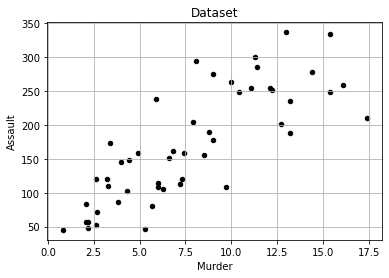

  centroid        name  Assault  Murder
0    empty     Alabama      236    13.2
1    empty      Alaska      263    10.0
2    empty     Arizona      294     8.1
3    empty    Arkansas      190     8.8
4    empty  California      276     9.0

------------------------------



In [ ]:
# read dataset

dataset = pd.read_csv('dataset/USArrests.csv', header=0)

df = dataset
df.rename(columns={'Unnamed: 0':'name'}, inplace=True)

df = df[['name', 'Assault', 'Murder']]

# infos
print("Dataset Infos")
print(df.describe())
print_line()

# plot dataset
plot_dataset(df, x='Murder', y='Assault', color='black', title='Dataset')


# add column
df.insert(0,'centroid', 'empty')

# first dataset rows
print(df[:5])
print_line()

Test distance method:
dist euc = 0.5192301994298868
dist ave = 0.5192301994298868
dist man = 0.6399999999999999

------------------------------

Test random init centroids method:
[{'name': '0', 'Assault': 304.275623617447, 'Murder': 5.295629793642971}, {'name': '1', 'Assault': 240.74589842199123, 'Murder': 5.9811452991229}, {'name': '2', 'Assault': 225.41114963660544, 'Murder': 12.299520307974616}, {'name': '3', 'Assault': 137.32879883122916, 'Murder': 2.114849965327198}, {'name': '4', 'Assault': 284.71993700939095, 'Murder': 7.708412873061411}, {'name': '5', 'Assault': 133.8934474861996, 'Murder': 14.819821476002055}]

------------------------------

Test min centroid:
  centroid  name     Assault     Murder
0    empty  Utah  120.000000   3.200000
1      NaN     0  304.275624   5.295630
2      NaN     1  240.745898   5.981145
3      NaN     2  225.411150  12.299520
4      NaN     3  137.328799   2.114850
5      NaN     4  284.719937   7.708413
6      NaN     5  133.893447  14.819821


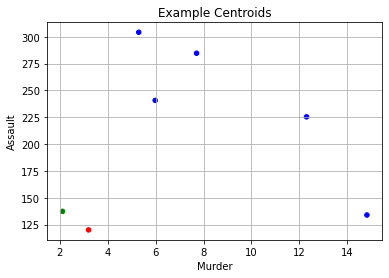


------------------------------



In [ ]:
# TESTs
k_param = 6

# """
# Test distance
xi = pd.DataFrame([{'x': 0.50, 'y': 0.43}])
xj = {'x': 1.00, 'y': 0.57}

print("Test distance method:")
for mode in ['euc', 'ave', 'man']:
  print("dist {} = {}".format(mode, distance(xi, xj, mode)))
print_line()

# Test init centroids
print("Test random init centroids method:")
centroids = init_centroids(df, k_param);
print(centroids)
print_line()

# Test min center
print("Test min centroid:")
sample = df.sample(n=1)
dfn = sample
# plot_dataset(dfn, x='Murder', y='Assault', color='red')

dfn = dfn.append(pd.DataFrame(centroids), ignore_index=True)


print(dfn)
print_line()

min = min_centroid(sample, centroids, 'euc')
print(min)


# plot color min center
colors = ['r']

for i in range(len(centroids)):
  if i == min:
    c = 'g'
  else:
    c = 'b'
  colors.append(c)

plot_dataset(dfn, x='Murder', y='Assault', color=colors, title='Example Centroids')
print_line()

# """

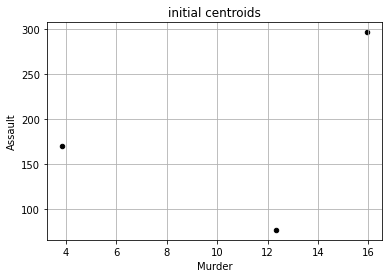

1

------------------------------

best centroids:
[{'name': '0', 'Assault': 87.55, 'Murder': 4.27}, {'name': '1', 'Assault': 173.28571428571428, 'Murder': 8.214285714285714}, {'name': '2', 'Assault': 272.5625, 'Murder': 11.8125}]

------------------------------



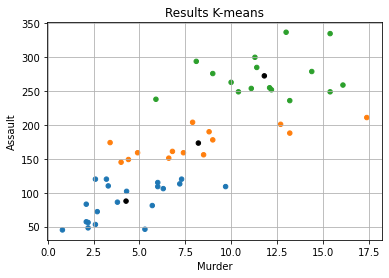


------------------------------



In [ ]:
# Test kmeans
k_param = 3
sample = df.sample(n=len(df))
sample = sample.reset_index(drop=True)
centroids = k_means(sample, k_param, 'euc', 1000)

print("best centroids:")
print(centroids)
print_line()

# plot k-means
dfn = pd.DataFrame(centroids)
dfn = dfn.append(sample, ignore_index=True)

colors = ['black'] * k_param

for i in range(len(sample)):
  c = sample.iloc[i]['centroid']
  colors.append('C'+c)

plot_dataset(dfn, x='Murder', y='Assault', color=colors, title='Results K-means')
print_line()
